# USA Crop Yield Forecast



## Install the necessary libraries to the Colab machine

In [0]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install gpytorch torch xgboost pyproj

     |████████████████████████████████| 194kB 3.4MB/s 
     |████████████████████████████████| 11.2MB 48.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/20/75/11/d5c644ac2b81bc933637a78a26d582577d114afa13da408027
Successfully built gpytorch


In [0]:
import gpytorch
import torch
import pickle
import joblib
import pyproj
import numpy as np
from torch import Tensor
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import xgboost as xgb
from sklearn.linear_model import LinearRegression

## Authenticate and mount google drive to the machine

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv("/content/drive/My Drive/data.csv")
data = data[(data["Year"]>=2000) & (data["month"] < 11)]

In [0]:
set(data["Year"])

{2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2014,
 2015,
 2016,
 2017,
 2018}

In [0]:
data[data["Year"]==2014]

,Unnamed: 0,X,State,Ag_District,month,Lat,Long,Year,erc,pr,rmin,tmmx,etr,eto,NDVI,prev,Crop_Yield
108,109,35493,ILLINOIS,CENTRAL,2,40.470153,-89.401797,2014,13.693486,17.603971,55.390955,285.446492,1.073331,0.755993,331.696013,187.8,218.5
109,110,35703,ILLINOIS,CENTRAL,3,40.470153,-89.401797,2014,23.989895,12.502219,41.244155,291.663118,2.632141,1.857757,2532.499374,187.8,218.5
110,111,35913,ILLINOIS,CENTRAL,4,40.470153,-89.401797,2014,31.055446,32.746120,36.480791,300.456231,5.332818,3.805321,3041.517988,187.8,218.5
111,112,36123,ILLINOIS,CENTRAL,5,40.470153,-89.401797,2014,34.542826,18.400052,37.809969,304.836770,6.687014,4.874070,4570.323262,187.8,218.5
112,113,36333,ILLINOIS,CENTRAL,6,40.470153,-89.401797,2014,29.449908,45.529988,44.396329,305.593519,7.096379,5.501215,7483.859315,187.8,218.5
113,114,36543,ILLINOIS,CENTRAL,7,40.470153,-89.401797,2014,33.327919,23.804979,40.177934,304.486738,7.580620,5.774858,8606.437584,187.8,218.5
114,115,36753,ILLINOIS,CENTRAL,8,40.470153,-89.401797,2014,33.137043,34.789864,44.104348,307.382252,5.881359,4.595946,8493.595207,187.8,218.5
115,116,36963,ILLINOIS,CENTRAL,9,40.470153,-89.401797,2014,26.188938,53.917691,39.975860,305.623082,5.232696,3.845311,5603.199232,187.8,218.5
116,117,37173,ILLINOIS,CENTRAL,10,40.470153,-89.401797,2014,24.044753,30.799108,42.514617,299.723574,3.706800,2.522793,3514.506500,187.8,218.5
252,253,35494,ILLINOIS,EAST,2,40.530301,-88.141232,2014,11.621658,17.760769,59.095330,285.128135,0.982445,0.704979,168.757320,174.4,202.6


In [0]:
# state variable names needed 
variables = ["State", "Ag_District", "month", "Lat", "Long", "Year", "erc", "pr", "rmin", "tmmx",\
             "etr", "eto", "NDVI", "prev", "Crop_Yield"]

xgb_variables = ["Lat", "Long", "Year", "erc", "pr", "rmin", "tmmx",\
             "etr", "eto", "NDVI", "prev"]
train_variables = ["Lat", "Long", "Year", "erc", "pr", "rmin", "tmmx",\
             "etr", "eto", "NDVI"]


In [0]:
# count the number of data for each month
for i in range(2,11):
    print(len(data[data["month"]==i]))

1272
1272
1272
1272
1272
1272
1272
1272
1272


In [0]:
set(data.month)

{2, 3, 4, 5, 6, 7, 8, 9, 10}

In [0]:
set(data[data["Year"]==2018].month)

{2, 3, 4, 5, 6, 7, 8, 9, 10}

In [0]:
data[data["Year"]==2017].head()

,Unnamed: 0,X,State,Ag_District,month,Lat,Long,Year,erc,pr,rmin,tmmx,etr,eto,NDVI,prev,Crop_Yield
135,136,42987,ILLINOIS,CENTRAL,2,40.470153,-89.401797,2017,25.780812,7.744127,45.138096,298.353621,3.149380,2.062796,2821.501285,218.6,219.1
136,137,43201,ILLINOIS,CENTRAL,3,40.470153,-89.401797,2017,30.916666,16.789311,38.525486,299.327445,3.534028,2.423273,3079.321027,218.6,219.1
137,138,43415,ILLINOIS,CENTRAL,4,40.470153,-89.401797,2017,25.040784,21.389656,39.250137,300.983648,5.605046,4.039893,3612.355007,218.6,219.1
138,139,43629,ILLINOIS,CENTRAL,5,40.470153,-89.401797,2017,23.754416,22.597293,45.259065,304.062798,5.704953,4.368321,4176.529584,218.6,219.1
139,140,43843,ILLINOIS,CENTRAL,6,40.470153,-89.401797,2017,37.083599,27.542219,37.966031,307.943372,8.149910,6.199919,6584.952213,218.6,219.1


## Define the Classes and functions needed for the model

In [0]:
class XGBoost_gp(gpytorch.models.ExactGP):
    """XGB-GP

    input:

        train_x: training features: Nxp dimensions
        train_y: training labels: Nx1 dimensions
        likelihood: Specify the likelihood function - from gpytorch classes
    """
    def __init__(self, train_x, train_y, likelihood, xgb_regression):
        """
        Define your mean functions and kernel here
        """
        super(XGBoost_gp, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ZeroMean()
        self.xgb_mean = xgb_regression
        self.covar_spatial = gpytorch.kernels.RBFKernel()
        self.covar_time = gpytorch.kernels.RBFKernel()
        self.covar_remote = gpytorch.kernels.ProductStructureKernel(gpytorch.kernels.RBFKernel(),7)
        
    
    def forward(self, x):
        """forward pass of GP model

        """
        spatial = x.narrow(1,0,2)
        year = x.narrow(1,2,1)
        remote = x.narrow(1,3,7)
        
        # compute mean
        x_pandas = pd.DataFrame(x.cpu().numpy(), columns = xgb_variables)
        data_x = xgb.DMatrix(data=x_pandas)
        predictions = self.xgb_mean.predict(data_x)
        mean = self.mean_module(x).view(-1) + Tensor(predictions).cuda()

        #compute covariances
        covar_time = self.covar_time(year)
        covar_spatial = self.covar_spatial(spatial)
        covar_remote = self.covar_remote(remote)
        covariance = covar_time*covar_spatial + covar_remote

        return gpytorch.distributions.MultivariateNormal(mean, covariance)

class Simple_GP(gpytorch.models.ExactGP):
    """Simple GP

    input:

        mean_function: mean function - from gpytorch classes or torch.nn
        train_x: training features: Nxp dimensions
        train_y: training labels: Nx1 dimensions
        likelihood: Specify the likelihood function - from gpytorch classes
    """
    def __init__(self, train_x, train_y, likelihood):
        """
        Define your mean functions and kernel here
        """
        super(Simple_GP, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_spatial = gpytorch.kernels.RBFKernel()
        self.covar_time = gpytorch.kernels.RBFKernel()
        self.covar_remote = gpytorch.kernels.MaternKernel()
    
    def forward(self, x):
        """forward pass of GP model

        """
        spatial = x.narrow(1,0,2)
        year = x.narrow(1,2,1)
        remote = x.narrow(1,3,7)
        
        # compute mean
        mean = self.mean_module(x).view(-1)
        
        #compute covariances
        covar_time = self.covar_time(year)
        covar_spatial = self.covar_spatial(spatial)
        covar_remote = self.covar_remote(remote)
        
        covariance = covar_time*covar_spatial + covar_remote

        return gpytorch.distributions.MultivariateNormal(mean, covariance)
    
def train_model(train_x, train_y, model, likelihood, epochs = 50):
    """training procedure

    input:

        model: model object
        likelihood: likelihood object
        epochs: number of training epochs

    output:

        model: trained posterior model

    """
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    if torch.cuda.is_available():
        likelihood = likelihood.cuda()
        model = model.cuda()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    marginal_likelihood = []

    for i in range(epochs):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        marginal_likelihood.append(loss.item())
        
        if (i+1) % 50 ==0:
            print("Iter {}/{} - Loss: {}".format(
                i + 1, epochs, loss.item()
            ))

        optimizer.step()

    return model, marginal_likelihood


def predict(test_x, model, likelihood):
    """compute posterior predictive mean and variance

    input:

        test_x: covariates of test in matrix form
        model: GP model object
        likelihood: likelihood object

    output:

        posterior_pred: return posterior prediction objected

    """

    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    # gpytorch.settings.fast_pred_var() for LOVE prediction
    with torch.no_grad():
        posterior_pred = likelihood(model(test_x))

    return posterior_pred
    



## Let's train and save our models

In [0]:
epochs = 80

# train models from month 2 to 11

for month in range(2,11):
    
    print("Month {}".format(month))
    # train xgboost model
    data_train = data[(data["month"] == month) & (data["Year"] <= 2016)]
    train_x = data_train[xgb_variables]
    train_y = data_train["Crop_Yield"]
    
    # linear regression
    lm = LinearRegression().fit(train_x, train_y)

    print("Begin XGBoost training")
    data_dmatrix = xgb.DMatrix(data=train_x,label=train_y)
    params = {"objective":"reg:squarederror",'learning_rate': 0.01,
                'max_depth': 5}
    xgb_regression = xgb.train(params, dtrain=data_dmatrix, num_boost_round=1000)
    print("End XGBoost Training")
    # define GP object
    # convert to tensors
    train_x = Tensor(train_x.values)
    train_y = Tensor(train_y.values)
    
    if torch.cuda.is_available():
        train_x = train_x.cuda()
        train_y = train_y.cuda()
    
    # initialize likelihood and model    
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    xgb_gp_model = XGBoost_gp(train_x, train_y, likelihood, xgb_regression)
    print("Start GP training for month {}\n".format(month))
    
    # simple GP training
    simple_gp_model = Simple_GP(train_x, train_y, likelihood)
    simple_gp_model, mll_gp = train_model(train_x, train_y, simple_gp_model, likelihood, epochs=epochs)
    
    # xgb gp training
    xgb_gp_model = XGBoost_gp(train_x, train_y, likelihood, xgb_regression)
    xgb_gp_model, mll_xgb_gp = train_model(train_x, train_y, xgb_gp_model, likelihood, epochs=epochs)
    
    print("End GP training for month {}\n".format(month))
    
    mll_record = pd.DataFrame({"epochs": np.linspace(1, epochs, epochs),
                               "simple_gp":mll_gp,
                               "xgb_gp": mll_xgb_gp,
                               })
    
    # save models to drive    
    mll_record.to_csv("/content/drive/My Drive/usa_results/mll_{}.csv".format(month))
    joblib.dump(xgb_regression, "/content/drive/My Drive/usa_results/xgb_{}.dat".format(month))
    joblib.dump(lm, "/content/drive/My Drive/usa_results/lm_{}.dat".format(month))
    torch.save(simple_gp_model.state_dict(), "/content/drive/My Drive/usa_results/gp_{}.pt".format(month))
    torch.save(xgb_gp_model.state_dict(), "/content/drive/My Drive/usa_results/xgb_gp_{}.pt".format(month))


Month 2
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 2

Iter 50/80 - Loss: 222.7176971435547
Iter 50/80 - Loss: 4.7111382484436035
End GP training for month 2

Month 3
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 3

Iter 50/80 - Loss: 222.3582000732422
Iter 50/80 - Loss: 4.849982261657715
End GP training for month 3

Month 4
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 4

Iter 50/80 - Loss: 219.10885620117188
Iter 50/80 - Loss: 4.356197357177734
End GP training for month 4

Month 5
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 5

Iter 50/80 - Loss: 221.08270263671875
Iter 50/80 - Loss: 4.394057750701904
End GP training for month 5

Month 6
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 6

Iter 50/80 - Loss: 220.42820739746094
Iter 50/80 - Loss: 4.303328514099121
End GP training for month 6

Month 7
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 7

Iter 50/80 - Loss: 219.47988891601562
Iter 50/80 - Loss: 3.8518974781036377
End GP training for month 7

Month 8
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 8

Iter 50/80 - Loss: 220.19500732421875
Iter 50/80 - Loss: 4.067668914794922
End GP training for month 8

Month 9
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 9

Iter 50/80 - Loss: 222.65194702148438
Iter 50/80 - Loss: 4.857361793518066
End GP training for month 9

Month 10
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 10

Iter 50/80 - Loss: 224.80682373046875
Iter 50/80 - Loss: 4.483781337738037
End GP training for month 10



## Generate some marginal likelihood plots


In [0]:
month = 9

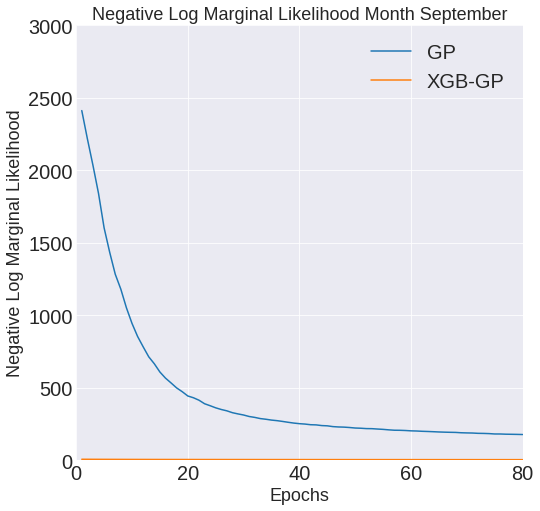

In [0]:
method = "gp"
mll_record = pd.read_csv("/content/drive/My Drive/usa_results/mll_{}.csv".format(month))

f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_xlim([0, 80])
ax.set_ylim([0, 3000])

if method == "gp":
    title = "GP"
if method == "xgb_gp":
    title = "XGB-GP"
if method == "xgb":
    title = "XGB"
plt.plot(mll_record["epochs"], mll_record["simple_gp"], label="GP")
plt.legend(loc='upper right', prop={'size': 20})
plt.plot(mll_record["epochs"], mll_record["xgb_gp"], label="XGB-GP")
plt.legend(loc='upper right', prop={'size': 20})
plt.title("Negative Log Marginal Likelihood Month September", fontsize=18)
plt.ylabel("Negative Log Marginal Likelihood", fontsize=18)
plt.xlabel("Epochs", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()
f.savefig("/content/drive/My Drive/usa_results/mll_plot_month_{}_{}.pdf".format(month,method))

In [0]:
mll_record

,Unnamed: 0,epochs,simple_gp,xgb_gp
0,0,1.0,2412.495850,7.181808
1,1,2.0,2218.698486,7.003588
2,2,3.0,2035.318726,6.850117
3,3,4.0,1840.906494,6.698119
4,4,5.0,1603.689575,6.572282
5,5,6.0,1435.298950,6.457482
6,6,7.0,1283.423584,6.356251
7,7,8.0,1180.280762,6.235217
8,8,9.0,1052.063843,6.145102
9,9,10.0,944.452515,6.056857


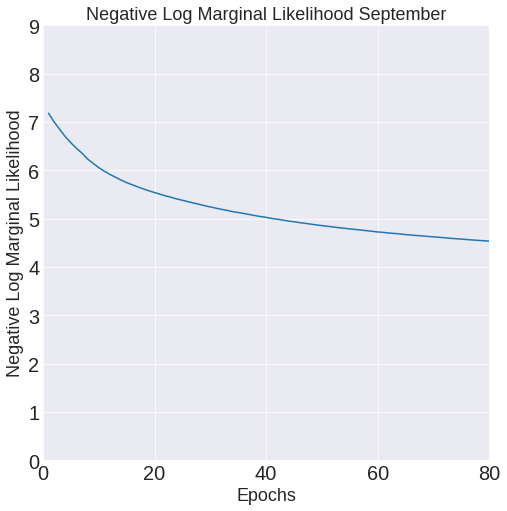

In [0]:
method = "xgb_gp"
mll_record = pd.read_csv("/content/drive/My Drive/usa_results/mll_{}.csv".format(month))

f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_xlim([0, 80])
ax.set_ylim([0, 9])

if method == "gp":
    title = "GP"
if method == "xgb_gp":
    title = "XGB-GP"
if method == "xgb":
    title = "XGB"
plt.plot(mll_record["epochs"], mll_record["xgb_gp"])
plt.title("Negative Log Marginal Likelihood September", fontsize=18)
plt.ylabel("Negative Log Marginal Likelihood", fontsize=18)
plt.xlabel("Epochs", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()
f.savefig("/content/drive/My Drive/usa_results/mll_plot_month_{}_{}.pdf".format(month,method))

## Let's make predictions

In [0]:
# make predictions

x_test_df = data[data["Year"]>=2017]

for month in range(2,11):

    # subset for month
    x_test = x_test_df[x_test_df["month"] == month]
    test_labels = x_test.loc[:,["State", "Ag_District", "Year", "month", "Crop_Yield"]]
    tmp = pd.DataFrame(test_labels)
    x_test = x_test[xgb_variables]

    # linear regression
    data_train = data[(data["month"] == month) & (data["Year"] <= 2016)]
    train_x = data_train[xgb_variables]
    train_y = data_train["Crop_Yield"]
    lm = LinearRegression().fit(train_x, train_y)
    lm_mean = lm.predict(x_test)
    
    # convert to Tensor
    x_test = Tensor(x_test.values)

    # enable cuda
    x_test = x_test.cuda()

    
    likelihood = likelihood.cuda()

    # load up xgb_gp model
    train_x = Tensor(train_x.values).cuda()
    train_y = Tensor(train_y.values).cuda()
    
    xgb_regression = pickle.load(open("/content/drive/My Drive/usa_results/xgb_{}.dat".format(month), 'rb'))
    xgb_gp_model = XGBoost_gp(train_x, train_y, likelihood, xgb_regression)
    xgb_gp_model.load_state_dict(torch.load("/content/drive/My Drive/usa_results/xgb_gp_{}.pt".format(month)))
    xgb_gp_model = xgb_gp_model.cuda()
    xgb_gp_posterior_pred = predict(x_test, xgb_gp_model, likelihood)
    
    # load up gp model
    gp_model = Simple_GP(train_x, train_y, likelihood)
    gp_model.load_state_dict(torch.load("/content/drive/My Drive/usa_results/gp_{}.pt".format(month)))
    gp_model = gp_model.cuda()
    gp_posterior_pred = predict(x_test, gp_model, likelihood)
    
    # pure xgb
    x_pandas = pd.DataFrame(x_test.cpu().numpy(), columns = xgb_variables)
    data_x = xgb.DMatrix(data=x_pandas)
    xgb_pred = xgb_regression.predict(data_x)
    
    # convert posteriors statistics to cpu -> numpy

    tmp["gp_mean"] = gp_posterior_pred.mean.cpu().numpy()
    tmp["gp_sd"] = gp_posterior_pred.stddev.cpu().numpy()
    tmp["xgb_gp_mean"] = xgb_gp_posterior_pred.mean.cpu().numpy()
    tmp["xgb_gp_sd"] = xgb_gp_posterior_pred.stddev.cpu().numpy()
    tmp["xgb"] = xgb_pred
    tmp["lm"] = lm_mean
    
    if month == 2:
        predictions = tmp
    else:
        predictions = pd.concat([predictions,tmp], axis=0)


In [0]:
xgb_gp_posterior_pred.mean

tensor([202.7476, 190.3026, 187.4603, 191.8532, 199.3847, 143.6939, 137.4724,
        194.6738, 190.1035, 199.6226, 105.1865, 199.8121, 104.2767, 203.5302,
        101.5546, 194.5184,  99.0323, 199.0255, 101.0900, 193.6384,  96.8108,
        194.6540,  99.1265, 195.2887,  99.6028, 197.6990, 108.2547, 132.5654,
        137.6727, 148.8198, 149.9197, 128.2709, 143.1629, 136.8326, 180.9875,
        121.9878, 127.5844, 110.5781, 136.8374, 135.8951, 159.3361, 173.3114,
        133.4934, 120.6677, 145.0939, 162.5627, 164.1099, 146.6115, 196.1850,
        180.4718, 176.9964, 202.5100, 193.9116, 200.7758, 184.5231, 181.6333,
        193.6812, 182.3221, 192.1217, 148.9116, 182.4075, 170.8307, 150.9965,
        163.4887, 130.9539, 157.2945, 141.3513, 169.1255, 108.2644, 132.7819,
        175.8771, 155.7565, 131.5269, 183.5222, 173.8345, 182.2208,  88.3635,
        110.9562, 181.6557, 178.1615, 176.5978, 149.1117, 147.3790, 178.1903,
        186.9140, 183.2882, 191.2626, 183.7016], device='cuda:0'

In [0]:
xgb_pred

array([202.74763 , 190.30261 , 187.46031 , 191.85316 , 199.38467 ,
       143.69394 , 137.47235 , 194.67375 , 190.10347 , 199.6226  ,
       105.18654 , 199.81212 , 104.27671 , 203.53021 , 101.55465 ,
       194.51836 ,  99.03233 , 199.02553 , 101.08998 , 193.63838 ,
        96.81077 , 194.654   ,  99.12649 , 195.28867 ,  99.60277 ,
       197.69899 , 108.25466 , 132.56541 , 137.67267 , 148.81984 ,
       149.9197  , 128.27086 , 143.16292 , 136.8326  , 180.98747 ,
       121.98781 , 127.58444 , 110.57808 , 136.83739 , 135.89508 ,
       159.33607 , 173.3114  , 133.49338 , 120.66771 , 145.09387 ,
       162.56265 , 164.1099  , 146.61151 , 196.18504 , 180.47177 ,
       176.9964  , 202.51003 , 193.91159 , 200.77576 , 184.52306 ,
       181.63329 , 193.68118 , 182.3221  , 192.12166 , 148.91156 ,
       182.40746 , 170.83073 , 150.99652 , 163.48868 , 130.95387 ,
       157.29446 , 141.35127 , 169.12553 , 108.264404, 132.7819  ,
       175.87706 , 155.75645 , 131.52695 , 183.5222  , 173.834

In [0]:
# read in BART predictions
bart_predictions = pd.read_csv("/content/drive/My Drive/BART_prediction_monthly_2019.csv")

In [0]:
predictions = pd.merge(predictions, bart_predictions, how="inner", on=["Year", "month", "State", "Ag_District"])

In [0]:
predictions.columns


Index(['State', 'Ag_District', 'Year', 'month', 'Crop_Yield', 'gp_mean',
       'gp_sd', 'xgb_gp_mean', 'xgb_gp_sd', 'xgb', 'lm', 'prediction_mean',
       'prediction_lower_95', 'prediction_upper_95'],
      dtype='object')

In [0]:
predictions.rename(columns={'prediction_mean':'bart_mean', 
                            'prediction_lower_95': 'bart_lower',
                            'prediction_upper_95': 'bart_upper'}, inplace=True)

In [0]:
predictions.head()

,State,Ag_District,Year,month,Crop_Yield,gp_mean,gp_sd,xgb_gp_mean,xgb_gp_sd,xgb,lm,bart_mean,bart_lower,bart_upper
0,ILLINOIS,CENTRAL,2017,2,219.1,135.816757,3.246174,194.526123,3.332984,194.523697,199.685160,133.473237,83.187971,183.636696
1,ILLINOIS,EAST,2017,2,204.1,131.378281,3.247736,180.942780,3.332855,180.993973,189.609120,122.320497,81.598739,161.674641
2,ILLINOIS,EAST SOUTHEAST,2017,2,184.3,115.585129,3.261732,174.753311,3.332992,174.753326,170.027066,110.928295,64.610600,155.254682
3,ILLINOIS,NORTHEAST,2017,2,200.2,135.595154,3.247945,187.504410,3.332989,187.501892,192.818715,115.737472,65.882885,164.842656
4,ILLINOIS,NORTHWEST,2017,2,213.7,144.009537,3.242333,191.641907,3.332968,191.641708,196.554390,144.328088,96.730922,198.716556


In [0]:
predictions.to_csv("/content/drive/My Drive/usa_results/predictions_2017_2018.csv")

## Let's compute RMSEs

In [0]:
# read from saved predictions
predictions = pd.read_csv("/content/drive/My Drive/usa_results/predictions_2017_2018.csv")

In [0]:
predictions.head()

,Unnamed: 0,State,Ag_District,Year,month,Crop_Yield,gp_mean,gp_sd,xgb_gp_mean,xgb_gp_sd,xgb,lm,bart_mean,bart_lower,bart_upper
0,0,ILLINOIS,CENTRAL,2017,2,219.1,135.81676,3.246174,194.52612,3.332984,194.52370,199.685160,133.473237,83.187971,183.636696
1,1,ILLINOIS,EAST,2017,2,204.1,131.37828,3.247736,180.94278,3.332855,180.99397,189.609120,122.320497,81.598739,161.674641
2,2,ILLINOIS,EAST SOUTHEAST,2017,2,184.3,115.58513,3.261732,174.75331,3.332992,174.75333,170.027066,110.928295,64.610600,155.254682
3,3,ILLINOIS,NORTHEAST,2017,2,200.2,135.59515,3.247945,187.50441,3.332989,187.50189,192.818715,115.737472,65.882885,164.842656
4,4,ILLINOIS,NORTHWEST,2017,2,213.7,144.00954,3.242333,191.64190,3.332968,191.64171,196.554390,144.328088,96.730922,198.716556


In [0]:
num = 0
for state in set(predictions.State):
    
    num += len(set(predictions[predictions["Year"]==2017].loc[predictions[predictions["Year"]==2017].State == state, "Ag_District"]))

In [0]:
num

79

In [0]:
gp_mse = np.sqrt(sum((predictions["Crop_Yield"].values - predictions["gp_mean"].values)**2) / predictions.shape[0])
xgb_gp_mse = np.sqrt(sum((predictions["Crop_Yield"].values - predictions["xgb_gp_mean"].values)**2) / predictions.shape[0])
xgb_mse = np.sqrt(sum((predictions["Crop_Yield"].values - predictions["xgb"].values)**2) / predictions.shape[0])
bart_mse = np.sqrt(sum((predictions["Crop_Yield"].values - predictions["bart_mean"].values)**2) / predictions.shape[0])
lm_mse = np.sqrt(sum((predictions["Crop_Yield"].values - predictions["lm"].values)**2) / predictions.shape[0])

print("GP MSE:{}".format(gp_mse))
print("XGB-GP MSE:{}".format(xgb_gp_mse))
print("XGB MSE:{}".format(xgb_mse))
print("BART MSE:{}".format(bart_mse))
print("LM MSE:{}".format(lm_mse))

GP MSE:61.71002672842737
XGB-GP MSE:33.87706349140328
XGB MSE:33.87538150901205
BART MSE:25.726991799353733
LM MSE:46.9386190754142


In [0]:
# MAPE
gp_mape = sum(np.abs(predictions["Crop_Yield"].values - predictions["gp_mean"].values) / predictions["Crop_Yield"].values) / predictions.shape[0] * 100
xgb_gp_mape = sum(np.abs(predictions["Crop_Yield"].values - predictions["xgb_gp_mean"].values) / predictions["Crop_Yield"].values) / predictions.shape[0] * 100
xgb_mape = sum(np.abs(predictions["Crop_Yield"].values - predictions["xgb"].values) / predictions["Crop_Yield"].values) / predictions.shape[0] * 100
bart_mape = sum(np.abs(predictions["Crop_Yield"].values - predictions["bart_mean"].values) / predictions["Crop_Yield"].values) / predictions.shape[0] * 100
lm_mape = sum(np.abs(predictions["Crop_Yield"].values - predictions["lm"].values) / predictions["Crop_Yield"].values) / predictions.shape[0] * 100

print("GP MAPE:{}".format(gp_mape))
print("XGB-GP MAPE:{}".format(xgb_gp_mape))
print("XGB MAPE:{}".format(xgb_mape))
print("BART MAPE:{}".format(bart_mape))
print("LM MAPE:{}".format(lm_mape))

GP MAPE:32.944128265826194
XGB-GP MAPE:12.745307148209815
XGB MAPE:12.745693941193753
BART MAPE:11.842106618475682
LM MAPE:14.939621793020965


## Let's plot the YY plot


In [0]:
def plot_yy(predictions, method):
    """plots cropyield: observed vs predicted
    
    """
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    mean = predictions["{}_mean".format(method)]
    lower = mean - 1.96*predictions["{}_sd".format(method)]
    upper = mean + 1.96*predictions["{}_sd".format(method)]
    ax.errorbar(predictions["Crop_Yield"], mean,
                yerr=[1.96*predictions["{}_sd".format(method)], 1.96*predictions["{}_sd".format(method)]],
                fmt='o', ls='none', capsize=5, markersize=4, color = "blue")
    #ax.scatter(predictions["Crop_Yield"], mean, marker=".")
    lims = [
        np.min([50, 50]),  # min of both axes
        np.max([260, 260]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    if method == "gp":
        title = "GP"
    if method == "xgb_gp":
        title = "XGB-GP"
    if method == "xgb":
        title = "XGB"
    
    plt.title("Crop Yield vs {} Prediction 2017-2018".format(title), fontsize=18)
    plt.xlabel("Observed Crop Yield bushels/acre", fontsize=18)
    plt.ylabel("Predicted Crop Yield bushels/acre", fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.show()
    f.savefig("/content/drive/My Drive/usa_results/yy_plot_2017_2018_{}.pdf".format(method))

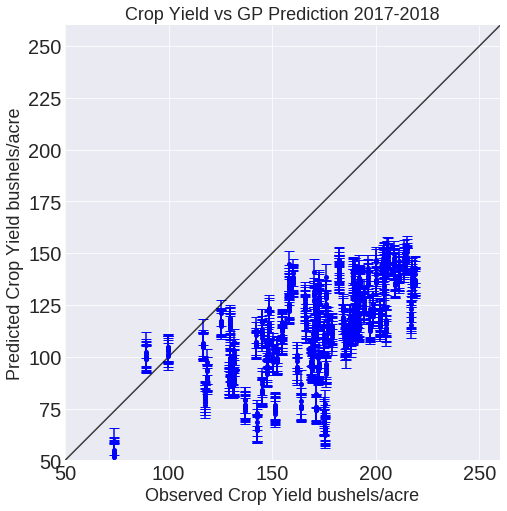

In [0]:
plot_yy(predictions, "gp")

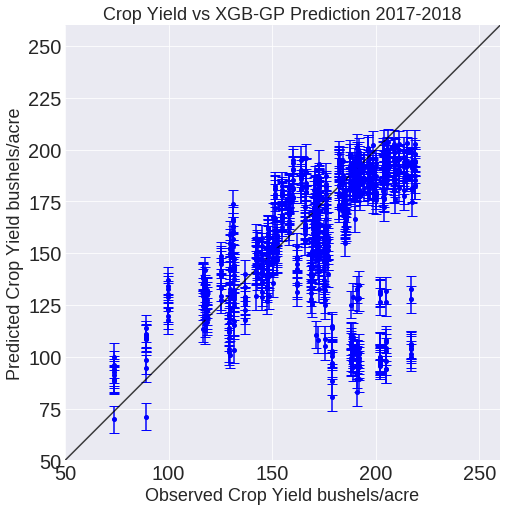

In [0]:
plot_yy(predictions, "xgb_gp")

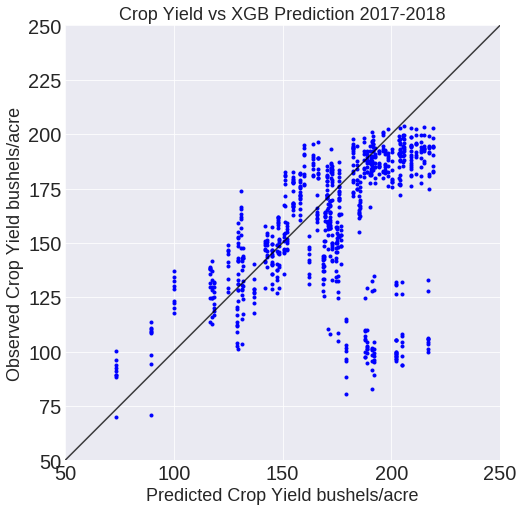

In [0]:
method="xgb"
f, ax = plt.subplots(1, 1, figsize=(8, 8))
mean = predictions["{}".format(method)]
ax.scatter(predictions["Crop_Yield"], mean, marker=".", color = "blue")

lims = [
    np.min([50, 50]),  # min of both axes
    np.max([250, 250]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

title = "XGB"
plt.title("Crop Yield vs {} Prediction 2017-2018".format(title), fontsize=18)
plt.ylabel("Observed Crop Yield bushels/acre", fontsize=18)
plt.xlabel("Predicted Crop Yield bushels/acre", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()
f.savefig("/content/drive/My Drive/usa_results/yy_plot_2017_2018_{}.pdf".format(method))

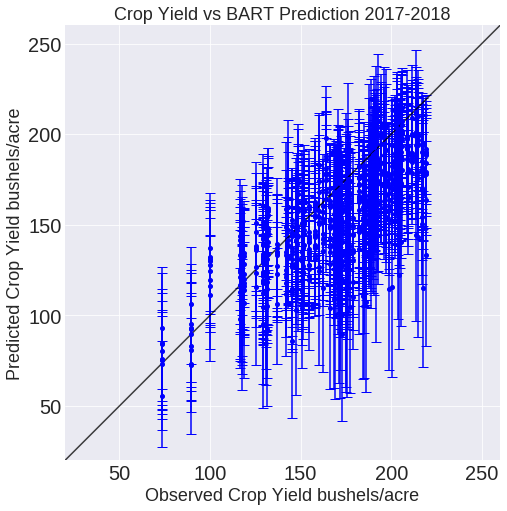

In [0]:
method = "bart"
title = "BART"
f, ax = plt.subplots(1, 1, figsize=(8, 8))
mean = predictions["{}_mean".format(method)]
lower = mean - predictions["bart_lower"]
upper = predictions["bart_upper"] - mean
ax.errorbar(predictions["Crop_Yield"], mean,
            yerr=[lower, upper],
            fmt='o', ls='none', capsize=5, markersize=4, color = "blue")
#ax.scatter(predictions["Crop_Yield"], mean, marker=".")
lims = [
    np.min([20, 20]),  # min of both axes
    np.max([260, 260]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.title("Crop Yield vs {} Prediction 2017-2018".format(title), fontsize=18)
plt.xlabel("Observed Crop Yield bushels/acre", fontsize=18)
plt.ylabel("Predicted Crop Yield bushels/acre", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()
f.savefig("/content/drive/My Drive/usa_results/yy_plot_2017_2018_{}.pdf".format(method))

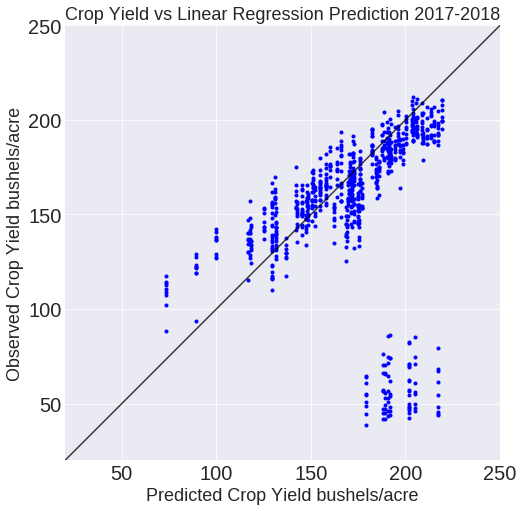

In [0]:
method = "lm"
title = "Linear Regression"
f, ax = plt.subplots(1, 1, figsize=(8, 8))
mean = predictions["lm"]
ax.scatter(predictions["Crop_Yield"], mean, marker=".", color = "blue")

lims = [
    np.min([20, 50]),  # min of both axes
    np.max([250, 250]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.title("Crop Yield vs {} Prediction 2017-2018".format(title), fontsize=18)
plt.ylabel("Observed Crop Yield bushels/acre", fontsize=18)
plt.xlabel("Predicted Crop Yield bushels/acre", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()
f.savefig("/content/drive/My Drive/usa_results/yy_plot_2017_2018_{}.pdf".format(method))

## Let's generate state-wise plots

In [0]:
def plot_state(predictions, state):    
    """plot state-wise predictions
    """
    state_df = predictions[predictions["State"]==state]
    f, ax = plt.subplots(3, 3, figsize=(18, 18))

    plot_num = 0
    for district in set(state_df.Ag_District):
        district_df = state_df[(state_df["Ag_District"] == district)]
        district_df = district_df.sort_values(by=['Year', "month"])
        district_yield = district_df["Crop_Yield"]
        district_predictions_gp = district_df["gp_mean"]
        district_predictions_xgb_gp = district_df["xgb_gp_mean"]
        district_predictions_xgb = district_df["xgb"]
        district_predictions_bart = district_df["bart_mean"]
        district_predictions_lm = district_df["lm"]

        district_df['date'] = district_df['month'].map(str)+ '-' +district_df['Year'].map(str)
        district_df['date'] = pd.to_datetime(district_df['date'], format='%m-%Y').dt.strftime('%m-%Y')

        plt.subplot(331 + plot_num)
        plt.xticks(rotation=70)
        plt.ylim(20,250)

        plt.plot(district_df['date'], district_yield, label="Actual")
        plt.legend(loc='lower left')
        plt.plot(district_df['date'], district_predictions_xgb_gp, label="Predicted XGB-GP")
        plt.legend(loc='lower left')
        plt.plot(district_df['date'], district_predictions_gp, label="Predicted GP")
        plt.legend(loc='lower left')
        plt.plot(district_df['date'], district_predictions_xgb, label="Predicted XGB")
        plt.legend(loc='lower left')
        plt.plot(district_df['date'], district_predictions_bart, label="Predicted BART")
        plt.legend(loc='lower left')
        plt.plot(district_df['date'], district_predictions_lm, label="Predicted LM")
        plt.legend(loc='lower left')
        plt.tick_params(axis='both', which='major', labelsize=10)
        
        plt.title(district + " {}".format(state))
        plt.ylabel("Crop Yield bushels/acre")
        plot_num += 1
    plt.show()
    f.savefig("/content/drive/My Drive/usa_results/{}_2017.png".format(state))

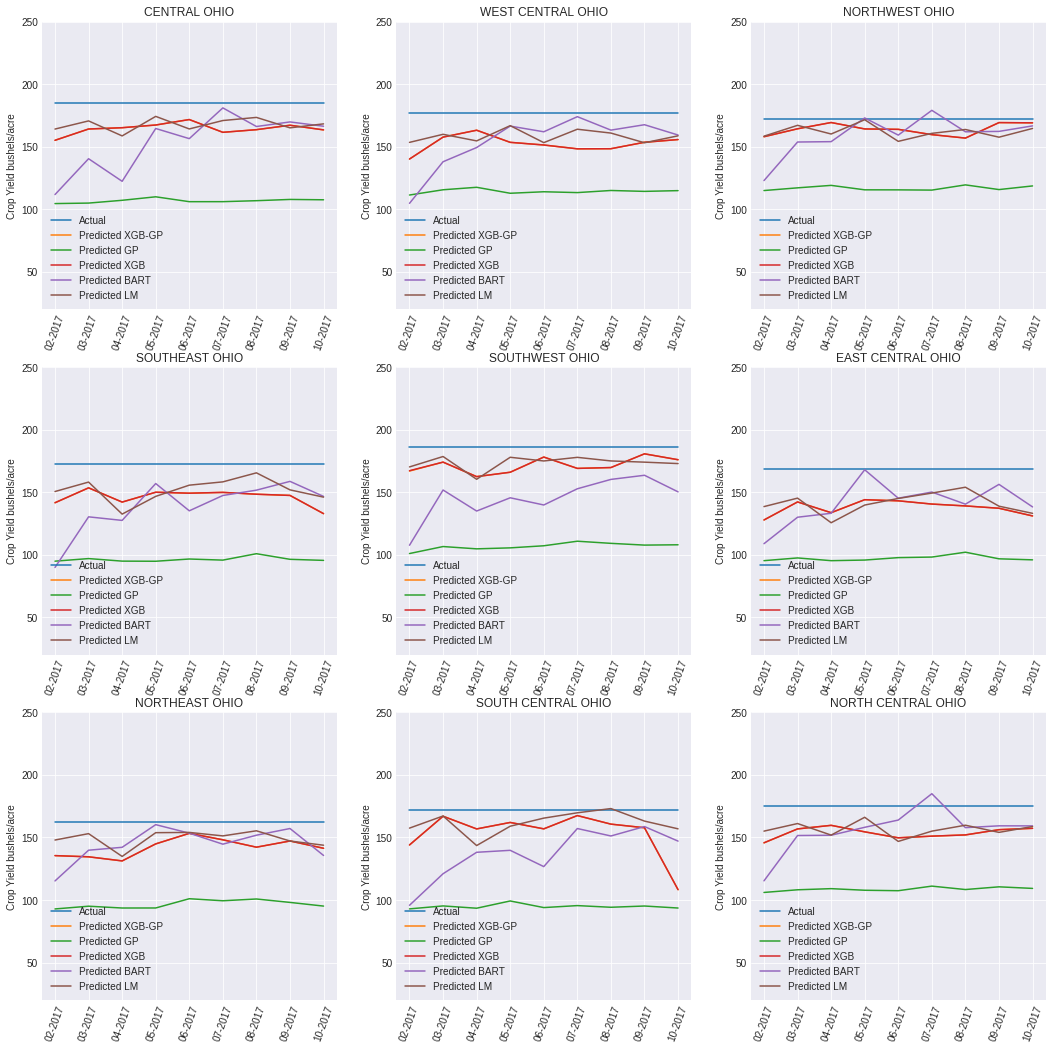

In [0]:
plot_state(predictions, "OHIO")

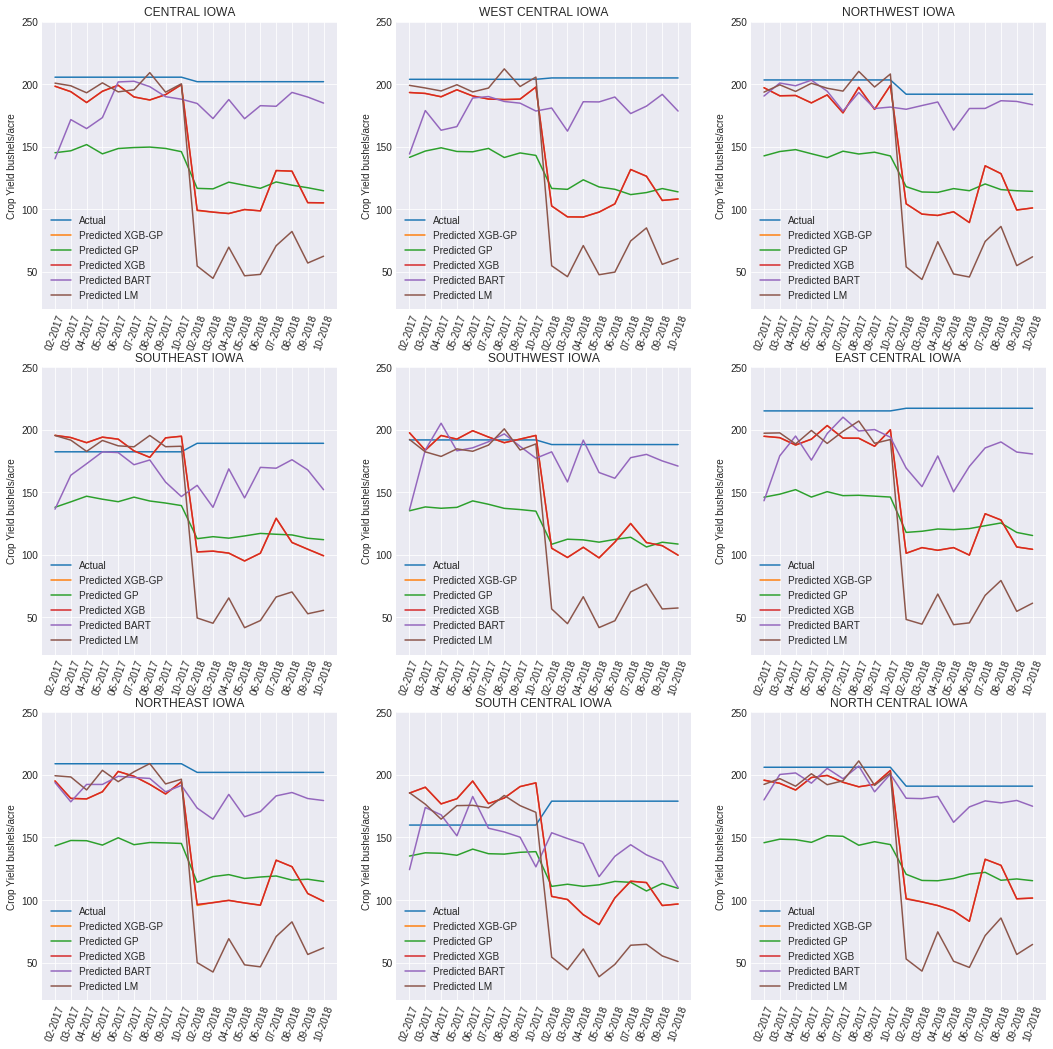

In [0]:
plot_state(predictions, "IOWA")

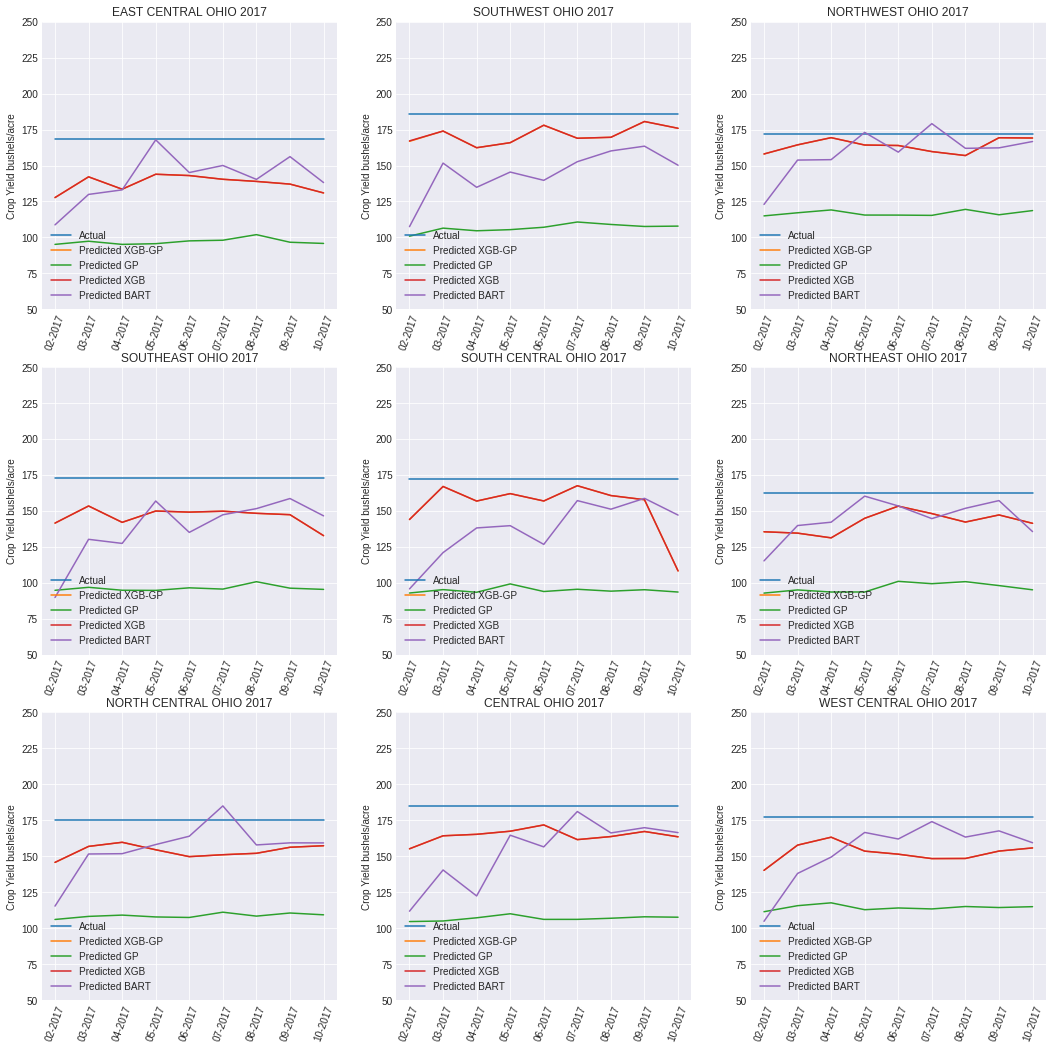

In [0]:
state = "OHIO"
state_df = predictions[predictions["State"]==state]
f, ax = plt.subplots(3, 3, figsize=(18, 18))

plot_num = 0
for district in set(state_df.Ag_District):
    district_df = state_df[(state_df["Ag_District"] == district)]
    district_df = district_df.sort_values(by=['Year', "month"])
    district_yield = district_df["Crop_Yield"]
    district_predictions_gp = district_df["gp_mean"]
    district_predictions_xgb_gp = district_df["xgb_gp_mean"]
    district_predictions_xgb = district_df["xgb"]
    district_predictions_bart = district_df["bart_mean"]

    district_df['date'] = district_df['month'].map(str)+ '-' +district_df['Year'].map(str)
    district_df['date'] = pd.to_datetime(district_df['date'], format='%m-%Y').dt.strftime('%m-%Y')

    plt.subplot(331 + plot_num)
    plt.xticks(rotation=70)
    plt.ylim(50,250)

    plt.plot(district_df['date'], district_yield, label="Actual")
    plt.legend(loc='lower left')
    plt.plot(district_df['date'], district_predictions_xgb_gp, label="Predicted XGB-GP")
    plt.legend(loc='lower left')
    plt.plot(district_df['date'], district_predictions_gp, label="Predicted GP")
    plt.legend(loc='lower left')
    plt.plot(district_df['date'], district_predictions_xgb, label="Predicted XGB")
    plt.legend(loc='lower left')
    plt.plot(district_df['date'], district_predictions_bart, label="Predicted BART")
    plt.legend(loc='lower left')

    plt.title(district + " {} 2017".format(state))
    plt.ylabel("Crop Yield bushels/acre")
    plot_num += 1
plt.show()
f.savefig("/content/drive/My Drive/usa_results/{}_2017.svg".format(state))